####Customer Churn Prediction using MLlib, PySpark
Here, customer churn prediction is modelled using logistic regression through MLLib which privides the advantage of real time big data processing using distributed compute.  
The dataset is extracted from [Kaggle](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset) which has features like Age, Gender, Tenure etc along with label indicating if the customer evevntually churned.

Creating a spark session to use Pyspark and MLlib for the churn modelling.

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("churnpred").getOrCreate()

Reading the data from table using spark SQL.

#### Data Import

In [0]:
data = spark.sql("select * from workspace.default.customer_churn_dataset")
data.show(3)
data.describe().show()

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         1| 22|Female|    25|             14|            4|           27|            Basic|        Monthly|        598|               9|    1|
|         2| 41|Female|    28|             28|            7|           13|         Standard|        Monthly|        584|              20|    0|
|         3| 47|  Male|    27|             10|            2|           29|          Premium|         Annual|        757|              21|    0|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------

Exploting the columns and the data types

In [0]:
data.printSchema()

root
 |-- CustomerID: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: long (nullable = true)
 |-- Usage Frequency: long (nullable = true)
 |-- Support Calls: long (nullable = true)
 |-- Payment Delay: long (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: long (nullable = true)
 |-- Last Interaction: long (nullable = true)
 |-- Churn: long (nullable = true)



Most of the features are numerical while there are 3 categorical features.

Using pandas API to explore the data with plots.

In [0]:
data_p = data.toPandas()
data_p.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


#### Exploration

Exploring the labels

<Axes: ylabel='Frequency'>

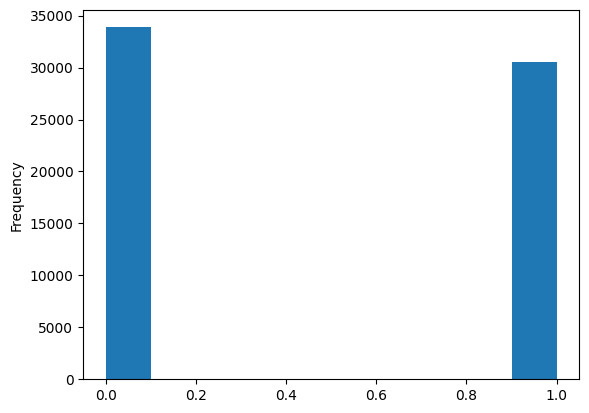

In [0]:
data_p['Churn'].plot(kind='hist')

The data does look well represented with sufficient examples from both churned[1] and not churned[0] scenarios

<Axes: ylabel='Frequency'>

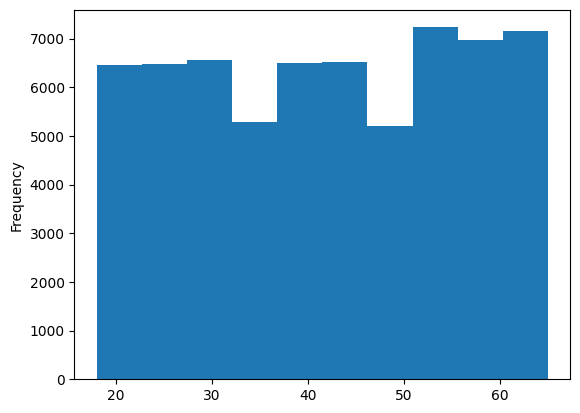

In [0]:
data_p['Age'].plot(kind='hist')

A wide range of age groups are present in the dataset. 

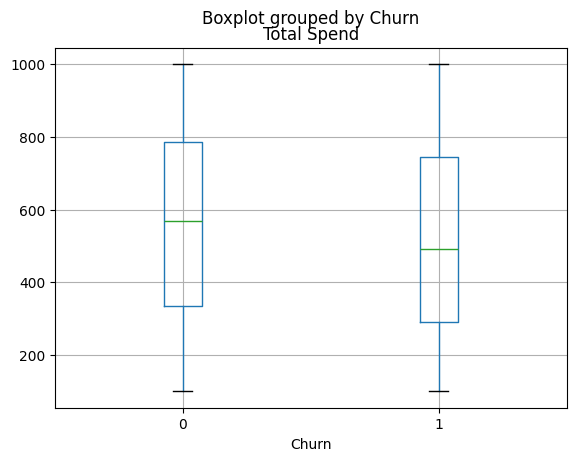

In [0]:
data_p.boxplot(column="Total Spend", by="Churn");

Less spends on average ins observed for churned customers while the range of spends is not different for both groups.

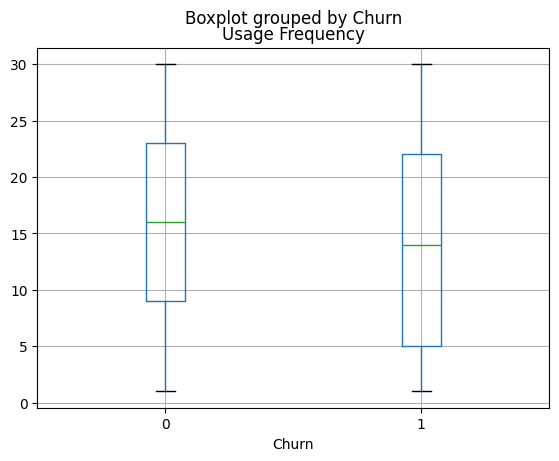

In [0]:
data_p.boxplot(column="Usage Frequency", by="Churn");

Slightly lower usage frequency on average is observed for churned customers.

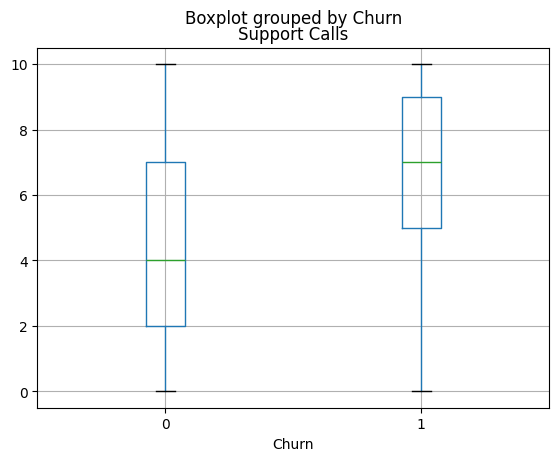

In [0]:
data_p.boxplot(column="Support Calls", by="Churn");

More support calls were observed for churned customers.

Checking for nulls

In [0]:
data.count()

64374

In [0]:
data.na.drop().count()

64374

#### Preparing the data for Model

**Preparing the data**  
MLlib requires the data to be numeric and each row of independent features assembled as vectors. The preparation is achieved using VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer from pyspark.

In [0]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [0]:
data.printSchema()

root
 |-- CustomerID: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: long (nullable = true)
 |-- Usage Frequency: long (nullable = true)
 |-- Support Calls: long (nullable = true)
 |-- Payment Delay: long (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: long (nullable = true)
 |-- Last Interaction: long (nullable = true)
 |-- Churn: long (nullable = true)



There are 3 categorical features `gender`, `Subscription Type` and `Contract Length` that we want to use in the model.  These need to be converted into numerical fields through encoding.

Firstly, the categorical columns are label encoded as pyspark's one hot encoder required numerical input. The resulting numerically encoded variable is one hot encoded.

In [0]:
gender_indexer = StringIndexer(inputCol='Gender', outputCol='Gender_indexed')
gender_encoder = OneHotEncoder(inputCol='Gender_indexed', outputCol='Gender_vec')

subscription_type_indexer = StringIndexer(inputCol='Subscription Type', outputCol='Subscription_Type_indexed')
subscription_type_encoder = OneHotEncoder(inputCol='Subscription_Type_indexed', outputCol='Subscription_Type_vec')

contract_length_indexer = StringIndexer(inputCol='Contract Length', outputCol='Contract_Length_indexed')
contract_length_encoder = OneHotEncoder(inputCol='Contract_Length_indexed', outputCol='Contract_Length_vec')

The assembler collects all the original and one hot encoded variables into vectors in the format that MLlib requires.

In [0]:
assembler = VectorAssembler(inputCols=['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction','Gender_vec','Contract_Length_vec','Subscription_Type_vec'], outputCol='features')

Only the encoder and assembler objects are created. All these oblects can be passed into a pipeline to each operation in a sequence. Importing the necessary model and pipeline libraries.

#### Training the Model

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

Model object is created 'Churn' as label and the expected 'features' from  the assembler as input features.

In [0]:
model = LogisticRegression(featuresCol='features', labelCol='Churn')
pipeline = Pipeline(stages=[gender_indexer, subscription_type_indexer, contract_length_indexer, gender_encoder, subscription_type_encoder, contract_length_encoder, assembler, model])    

All the objectss of preparation stage are added as stages to pipeline including the model object in the end. The pipeline object can be used to fit the data to the model directly. Creating a train test split before fitting the model.

In [0]:
train_data, test_data = data.randomSplit([0.7,0.3])

Fitting the train data to the model

In [0]:
fit_model = pipeline.fit(train_data)

The transform method is used on the fitted model to make predictions and to evaluate further.

#### Results and Evaluations

In [0]:
results = fit_model.transform(test_data)

In [0]:
results.printSchema()

root
 |-- CustomerID: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: long (nullable = true)
 |-- Usage Frequency: long (nullable = true)
 |-- Support Calls: long (nullable = true)
 |-- Payment Delay: long (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: long (nullable = true)
 |-- Last Interaction: long (nullable = true)
 |-- Churn: long (nullable = true)
 |-- Gender_indexed: double (nullable = false)
 |-- Subscription_Type_indexed: double (nullable = false)
 |-- Contract_Length_indexed: double (nullable = false)
 |-- Gender_vec: vectorudt (nullable = true)
 |-- Subscription_Type_vec: vectorudt (nullable = true)
 |-- Contract_Length_vec: vectorudt (nullable = true)
 |-- features: vectorudt (nullable = true)
 |-- rawPrediction: vectorudt (nullable = true)
 |-- probability: vectorudt (nullable = true)
 |-- prediction: double (nullable = false)



In [0]:
results.select(['prediction','Churn']).show(3)

+----------+-----+
|prediction|Churn|
+----------+-----+
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 3 rows


Getting the Area under ROC curve

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol='Churn')

print(f"AUC is {round(evaluator.evaluate(results),4):.2%}")

AUC is 82.73%
